In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction import text 

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


from sklearn.decomposition import LatentDirichletAllocation

from nltk.corpus import stopwords

In [2]:
# connect to SQL database and convert to dataframes

cnx = sqlite3.connect('../data/database.sqlite')

categories = pd.read_sql_query("SELECT * FROM categories", cnx)
reviews = pd.read_sql_query("SELECT * FROM reviews", cnx)
podcasts = pd.read_sql_query("SELECT * FROM podcasts", cnx)

In [3]:
# top 5 grossing podcasts according to statista

podcasts[podcasts['slug'].str.contains('armchair')]
podcasts[podcasts['slug'].str.contains('joe-rogan')]
podcasts[podcasts['slug'].str.contains('my-favorite')]
podcasts[podcasts['slug'].str.contains('dave-ram')]
podcasts[podcasts['slug'].str.contains('bill-simmons')]

,podcast_id,itunes_id,slug,itunes_url,title


In [4]:
# categories for armchair expert
print(categories[categories['podcast_id'] == 'd4baff0192b5f556b0c3f2a273e98e93'])

# categories for JRE
print(categories[categories['podcast_id'] == 'db93a05fe337aea2061b59c96e647100'])

# categories for my favorite murder
print(categories[categories['podcast_id'] == 'bc5ddad3898e0973eb541577d1df8004'])

                             podcast_id category
10736  d4baff0192b5f556b0c3f2a273e98e93   comedy
10737  d4baff0192b5f556b0c3f2a273e98e93  tv-film
                             podcast_id category
10731  db93a05fe337aea2061b59c96e647100   comedy
                             podcast_id category
10732  bc5ddad3898e0973eb541577d1df8004   comedy


In [5]:
# merge categories and reviews columns to collect comedy review data

reviews_categories = pd.merge(reviews, categories)
comedy_reviews = reviews_categories[reviews_categories['category'] == 'comedy']
print('{} total comedy reviews'.format(len(comedy_reviews)))
print('{} unique comedy podcasts'.format(len(comedy_reviews['podcast_id'].unique())))

249482 total comedy reviews
8080 unique comedy podcasts


In [37]:
# extract comedy reviews from dataframe

print('{} total comedy reviews'.format(len(comedy_reviews)))

X = comedy_reviews['content']
y = comedy_reviews['rating'].apply(lambda x: 1 if x > 3 else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y)

249482 total comedy reviews


In [7]:
# dummy modeling

dclf_stratified = DummyClassifier(strategy = 'stratified')
dclf_stratified.fit(X_train, y_train)
predicted_stratified = dclf_stratified.predict(X_test)
print(classification_report(y_test, predicted_stratified))

              precision    recall  f1-score   support

           0       0.10      0.10      0.10      6246
           1       0.90      0.90      0.90     56125

    accuracy                           0.82     62371
   macro avg       0.50      0.50      0.50     62371
weighted avg       0.82      0.82      0.82     62371



In [8]:
# preliminary model
sw = stopwords.words("english")

mult_nb = Pipeline([
    ('vect', CountVectorizer(stop_words = sw)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

mult_nb.fit(X_train, y_train)
predicted = mult_nb.predict(X_test)

print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.86      0.03      0.06      6246
           1       0.90      1.00      0.95     56125

    accuracy                           0.90     62371
   macro avg       0.88      0.52      0.50     62371
weighted avg       0.90      0.90      0.86     62371



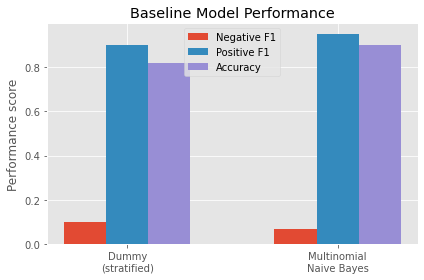

In [9]:
# visualize baseline model performance

labels = ['Dummy\n(stratified)', 'Multinomial\nNaive Bayes']
neg_f1 = [0.1, .07]
pos_f1 = [0.9, .95]
acc = [0.82, 0.90]

x = np.arange(len(labels))
width = 0.2 

fig, ax = plt.subplots()
ax.bar(x - width, neg_f1, width, label='Negative F1')
ax.bar(x, pos_f1, width, label='Positive F1')
ax.bar(x + width, acc, width, label='Accuracy')

ax.set_ylabel('Performance score')
ax.set_title('Baseline Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.savefig('../img/baseline_model_performance.png', dpi=300)

In [38]:
# oversample from minority class for training data

X_train = np.array(X_train).reshape(-1,1)
y_train = np.array(y_train)

ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

X_train_resampled = np.concatenate(X_resampled, axis=0)
y_train_resampled = y_resampled
X_train_resampled.shape

(337222,)

In [12]:
# expand stop words based on high count words

vectorizer = CountVectorizer(stop_words=sw)
word_counts = vectorizer.fit_transform(X_train.ravel()).sum(axis=0)
features = vectorizer.get_feature_names()

counts_df = pd.DataFrame(index=features, data=word_counts.T, columns=['counts'])
counts_df.sort_values('counts', ascending=False, inplace=True)

counts_df[:30]

,counts
podcast,100715
love,71077
listen,38435
like,37726
great,36863
show,35611
listening,29116
one,25820
guys,25333
funny,24095


In [13]:
sw = stopwords.words("english")
podcast_sw = ['podcast','episode','get','keep','episodes','podcasts','would']
updated_sw = sw + podcast_sw

In [17]:
# rerun the model with oversampling, new stop words, bigrams

mult_nb = Pipeline([
    ('vect', CountVectorizer(stop_words = updated_sw, ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
mult_nb.fit(X_train_resampled, y_train_resampled)
predicted = mult_nb.predict(X_test)

print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.47      0.89      0.62      6246
           1       0.99      0.89      0.93     56125

    accuracy                           0.89     62371
   macro avg       0.73      0.89      0.77     62371
weighted avg       0.94      0.89      0.90     62371



In [ ]:
# comp_nb = Pipeline([
#     ('vect', CountVectorizer(stop_words = updated_sw, ngram_range=(1,2))),
#     ('tfidf', TfidfTransformer()),
#     ('clf', ComplementNB()),
# ])
# mult_nb.fit(X_train_resampled, y_train_resampled)
# predicted = mult_nb.predict(X_test)

# print(classification_report(y_test, predicted))

In [39]:
sgdc = Pipeline([
    ('vect', CountVectorizer(stop_words = updated_sw, ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

sgdc.fit(X_train_resampled, y_train_resampled)
predicted = sgdc.predict(X_test)

print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.46      0.86      0.60      6163
           1       0.98      0.89      0.93     56208

    accuracy                           0.89     62371
   macro avg       0.72      0.88      0.77     62371
weighted avg       0.93      0.89      0.90     62371



In [ ]:
# rf = Pipeline([
#     ('vect', CountVectorizer(stop_words = updated_sw)),
#     ('tfidf', TfidfTransformer()),
#     ('clf', RandomForestClassifier(n_estimators=10)),
# ])

# rf.fit(X_train_resampled, y_train_resampled)
# predicted = rf.predict(X_test)

# print(classification_report(y_test, predicted))

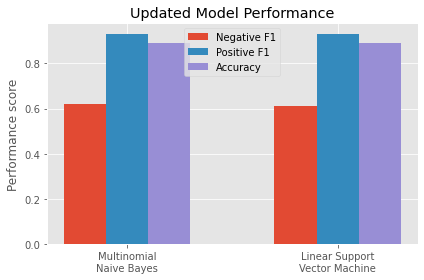

In [18]:
# visualize model performance with random oversampling

labels = ['Multinomial\nNaive Bayes', 'Linear Support\nVector Machine']
neg_f1 = [0.62, .61]
pos_f1 = [0.93, .93]
acc = [0.89, 0.89]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
ax.bar(x - width, neg_f1, width, label='Negative F1')
ax.bar(x, pos_f1, width, label='Positive F1')
ax.bar(x + width, acc, width, label='Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance score')
ax.set_title('Updated Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.savefig('../img/updated_model_performance.png', dpi=300)

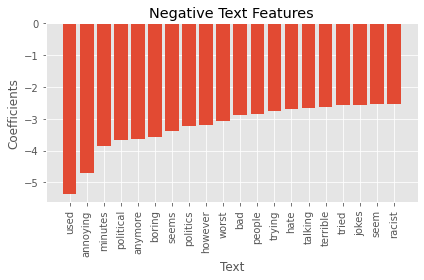

In [29]:
# interpret model features to extract information about common phrases in
# positive vs negative reviews

text_features = sgdc.named_steps.vect.get_feature_names()
model_coefs = sgdc.named_steps.clf.coef_

text_coefs = pd.DataFrame(index=text_features, data={'coefs': model_coefs[0]})
text_coefs = text_coefs.iloc[(text_coefs['coefs']).argsort()]

fig, ax = plt.subplots()
ax.bar(text_coefs.index[:20], text_coefs['coefs'][:20].values)
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('Negative Text Features')
ax.set_ylabel('Coefficients')
ax.set_xlabel('Text')
plt.tight_layout()
plt.savefig('../img/negative_text_coefficients.png', dpi=300)

In [25]:
text_coefs_rev = text_coefs[::-1]
text_coefs_rev[:20]

,coefs
love,6.557332
great,4.874908
hilarious,4.613407
thank,4.555902
best,4.500406
amazing,3.482719
thanks,3.322343
favorite,3.302282
life,2.900759
always,2.751827


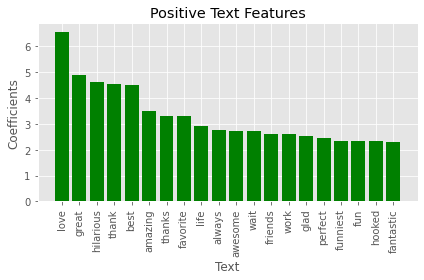

In [30]:
fig, ax = plt.subplots()
ax.bar(text_coefs_rev.index[:20], text_coefs_rev['coefs'][:20].values, color='green')
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('Positive Text Features')
ax.set_ylabel('Coefficients')
ax.set_xlabel('Text')
plt.tight_layout()
plt.savefig('../img/positive_text_coefficients.png', dpi=300)

In [32]:
# repeat analysis for business podcasts

business_reviews = reviews_categories[reviews_categories['category'] == 'business']

X = business_reviews['content']
y = business_reviews['rating'].apply(lambda x: 1 if x > 3 else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train = np.array(X_train).reshape(-1,1)
y_train = np.array(y_train)

ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

X_train_resampled = np.concatenate(X_resampled, axis=0)
y_train_resampled = y_resampled


In [33]:
sgdc = Pipeline([
    ('vect', CountVectorizer(stop_words = updated_sw, ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

sgdc.fit(X_train_resampled, y_train_resampled)
predicted = sgdc.predict(X_test)

print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.48      0.87      0.62      1561
           1       0.99      0.95      0.97     31574

    accuracy                           0.95     33135
   macro avg       0.74      0.91      0.80     33135
weighted avg       0.97      0.95      0.96     33135



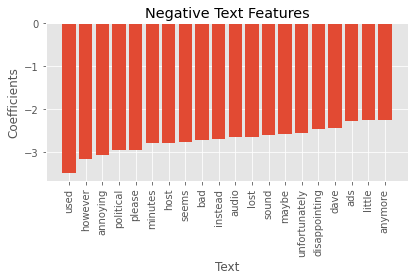

In [34]:
text_features = sgdc.named_steps.vect.get_feature_names()
model_coefs = sgdc.named_steps.clf.coef_

text_coefs = pd.DataFrame(index=text_features, data={'coefs': model_coefs[0]})
text_coefs = text_coefs.iloc[(text_coefs['coefs']).argsort()]

fig, ax = plt.subplots()
ax.bar(text_coefs.index[:20], text_coefs['coefs'][:20].values)
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('Negative Text Features')
ax.set_ylabel('Coefficients')
ax.set_xlabel('Text')
plt.tight_layout()
plt.savefig('../img/business_negative_text_coefficients.png', dpi=300)

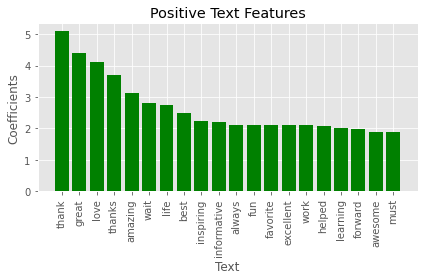

In [40]:
text_coefs_rev = text_coefs[::-1]
text_coefs_rev[:20]

fig, ax = plt.subplots()
ax.bar(text_coefs_rev.index[:20], text_coefs_rev['coefs'][:20].values, color='green')
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('Positive Text Features')
ax.set_ylabel('Coefficients')
ax.set_xlabel('Text')
plt.tight_layout()
plt.savefig('../img/business_positive_text_coefficients.png', dpi=300)